## Final project notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

/var/folders/9q/f1tj90w176qgctk31mz60mcw0000gn/T/ipykernel_2031/328324305.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Jellyfish abundance data: timeseries and relative abundance

In [20]:
filename07 = 'jelly_abundance_combined.csv'
jelly_ab = pd.read_csv(filename07,header=1)

In [21]:
jelly_ab

,year,abundance,species_group
0,1990,0.247798,Chrysaora
1,1991,0.282914,Chrysaora
2,1992,1.382158,Chrysaora
3,1993,0.531131,Chrysaora
4,1994,0.468061,Chrysaora
...,...,...,...
64,2011,3.901225,Aequorea
65,2012,7.649971,Aequorea
66,2013,3.498627,Aequorea
67,2014,6.548705,Aequorea


In [22]:
# Aequorea abundance 2016: 5.160066282

In [23]:
chrysaora = jelly_ab[(jelly_ab['species_group'] == 'Chrysaora')]
aurelia = jelly_ab[(jelly_ab['species_group'] == 'Aurelia')]
aequorea = jelly_ab[(jelly_ab['species_group'] == 'Aequorea')]

In [24]:
#chrysaora trend line
p = np.polyfit(chrysaora['year'], chrysaora['abundance'], 1)
slope = p[0]
intercept = p[1]
chry_bestfit = slope * chrysaora['year'] + intercept
# chry_bestfit
print(slope)

0.3152866847620536


In [25]:
# aequorea trend line
aq_p = np.polyfit(aequorea['year'], aequorea['abundance'], 1)
aq_slope = aq_p[0]
aq_intercept = aq_p[1]
aequo_bestfit = aq_slope * aequorea['year'] + aq_intercept
print(aq_slope)

-0.020589682166662796


In [26]:
# aurelia trend line
aur_p = np.polyfit(aurelia['year'], aurelia['abundance'], 1)
aur_slope = aur_p[0]
aur_intercept = aur_p[1]
aurelia_bestfit = aur_slope * aurelia['year'] + aur_intercept
print(aur_slope)

0.000182606998290419


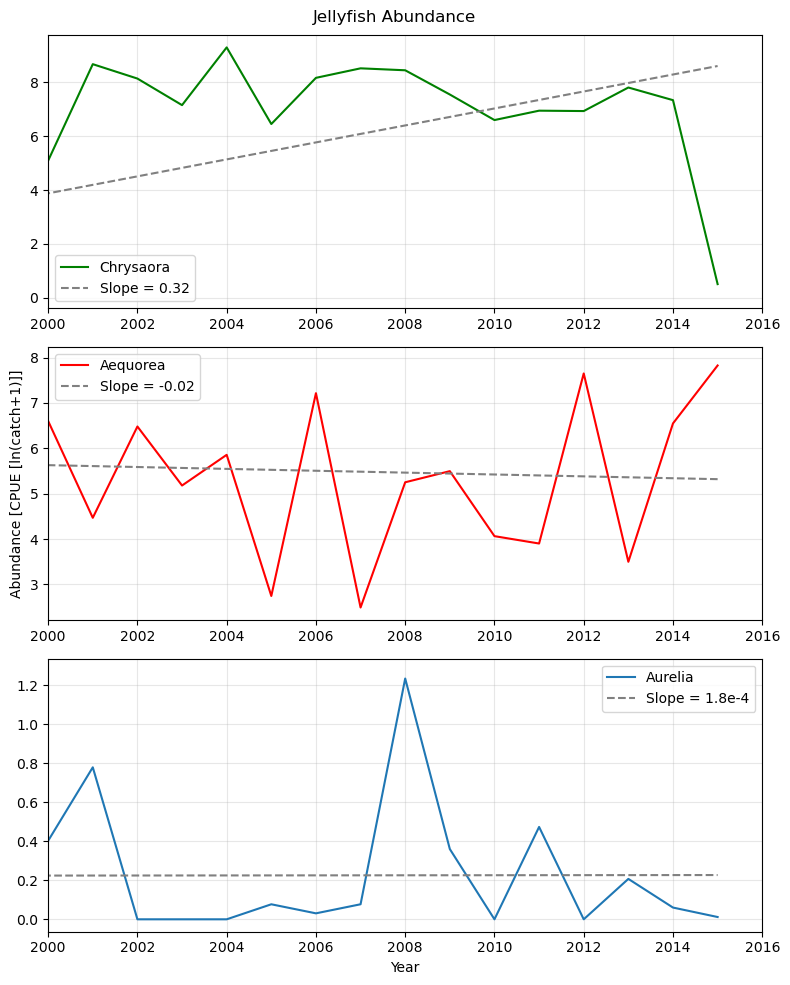

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

axes[0].plot(chrysaora['year'], chrysaora['abundance'], 'g', label='Chrysaora')
axes[0].plot(chrysaora['year'], chry_bestfit, 'grey', linestyle='--', label='Slope = 0.32')
axes[0].set_xlim([2000, 2016])
axes[1].plot(aequorea['year'], aequorea['abundance'], 'r', label='Aequorea')
axes[1].plot(aequorea['year'], aequo_bestfit, 'grey', linestyle='--', label='Slope = -0.02')
axes[1].set_xlim([2000, 2016])
axes[2].plot(aurelia['year'], aurelia['abundance'], label='Aurelia')
axes[2].plot(aurelia['year'], aurelia_bestfit, 'grey', linestyle='--', label='Slope = 1.8e-4')
axes[2].set_xlim([2000, 2016])

axes[0].legend()
axes[1].legend()
axes[2].legend()

axes[0].grid(alpha=0.3)
axes[1].grid(alpha=0.3)
axes[2].grid(alpha=0.3)

fig.suptitle('Jellyfish Abundance')
plt.xlabel('Year')
axes[1].set_ylabel('Abundance [CPUE [ln(catch+1)]]')

plt.tight_layout()
plt.show()

In [28]:
from SJ_tools import final_proj_functions as fpf

In [29]:
richness = 3
N = np.sum(jelly_ab['abundance']) #total biomass of all 3 genera
ni_chry = np.sum(chrysaora['abundance']) #total biomass of target genus
ni_aequo = np.sum(aequorea['abundance'])
ni_aurelia = np.sum(aurelia['abundance'])

In [30]:
chry_rel_ab = fpf.relative_abundance(richness, N, ni_chry)
aequo_rel_ab = fpf.relative_abundance(richness, N, ni_aequo)
aurelia_rel_ab = fpf.relative_abundance(richness, N, ni_aurelia)

In [31]:
print(chry_rel_ab)
print(aequo_rel_ab)
print(aurelia_rel_ab)

0.3286202145366619
0.3639372065898945
0.09619284658452551


In [32]:
genera = ['Chrysaora', 'Aequorea', 'Aurelia']
print(genera)

['Chrysaora', 'Aequorea', 'Aurelia']


In [33]:
relative_abundance = [chry_rel_ab, aequo_rel_ab, aurelia_rel_ab]
relative_abundance

[0.3286202145366619, 0.3639372065898945, 0.09619284658452551]

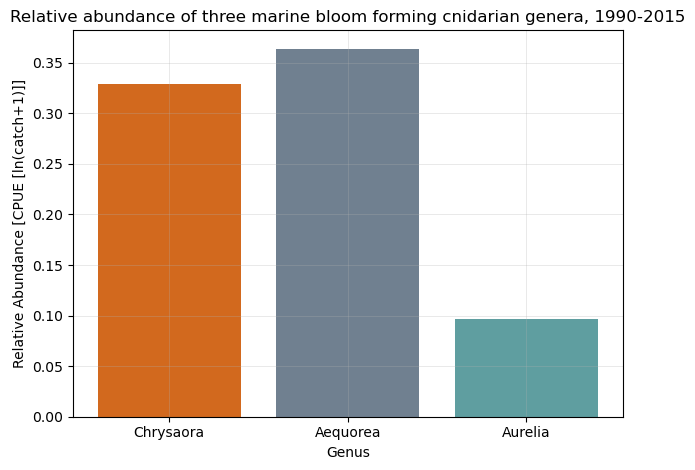

In [35]:
plt.figure()
plt.bar(genera, relative_abundance, color=['chocolate', 'slategray', 'cadetblue'])
plt.ylabel('Relative Abundance [CPUE [ln(catch+1)]]')
plt.xlabel('Genus')
plt.title('Relative abundance of three marine bloom forming cnidarian genera, 1990-2015')
plt.grid(linewidth=0.5, alpha=0.4)
plt.tight_layout()

### Chlorophyll data

In [17]:
import os
import numpy as np

In [10]:
# can't use this until i get all the years into csvs

# df_chl = pd.DataFrame()

# for file in chl_files:
#     df = pd.read_csv(file)
#     df_chl = pd.concat([df_chl, df], ignore_index=True)

In [51]:
chlor_folder = '/Volumes/TOSHIBAEXT/Thesis_data/Chlor-a'

Only to be run once per data year to save all years into separate CSV files

Change file year!!

----- Start -----

In [134]:
chlor_data_files = []

for file_name in os.listdir(chlor_folder):
    if file_name[:4] =='AQUA':
        file_year = 2008
        year = int(file_name[11:15])
        if year == file_year:
            chlor_data_files.append(file_name)

chlor_data_files.sort()

print(len(chlor_data_files))

366


In [135]:
# AQUA_MODIS.20020901.L3m.DAY.CHL.chlor_a.4km

chlor_date_list = []

for file_name in chlor_data_files:
    year = int(file_name[11:15])
    if year == file_year:
        month = file_name.split('.')[1][4:6]
        day = file_name.split('.')[1][6:8]
        
    chlor_date_string = str(year)+'-'+month+'-'+day
    chlor_date_list.append(chlor_date_string)

#print(chlor_date_list)

chlor_date_array = np.array(chlor_date_list, dtype='datetime64')

print(chlor_date_array[0])

2008-01-01


In [45]:
# def YMD_to_DecYr(year, month, day):
    
#     # define a date object using the datetime module
#     date = dt.datetime(year, month, day)

#     # to calculate decimal year: year + (time elapsed in year/total time in year)
#     # define the start in ordinal units (days since ...)
#     start = dt.date(year, 1, 1).toordinal()

#     # compute the year_length in ordinal units (365 or 366)
#     year_length = dt.date(year+1, 1, 1).toordinal() - start

#     # compute the fraction based on the date
#     decimal_fraction = (date.toordinal() - start) / year_length

#     # compute the decimal year
#     decimal_year = year + decimal_fraction
    
#     #return
#     return(decimal_year)

# might not need to make dates into decimal years - excel might be weird about it so avoid if possible

In [46]:
# decyrs = []

# for date in chlor_date_array:
#     datetime_date = date.astype(dt.datetime)
#     yr = datetime_date.year
#     mo = datetime_date.month
#     dy = datetime_date.day
#     dec_yr = YMD_to_DecYr(yr, mo, dy)
#     decyrs.append(dec_yr)

# decyrs = np.array(decyrs)

In [95]:
def read_chl_from_file(file_path):

    ds = nc4.Dataset(file_path)

    modis_lat = np.array(ds.variables['lat'])
    modis_lon = np.array(ds.variables['lon'])
    modis_chl = np.array(ds.variables['chlor_a'])

    ds.close()
    
    site_lon = -121.9
    site_lat = 36.8
    
    lat_index_chl = np.argmin(np.abs(modis_lat-site_lat))
    lon_index_chl = np.argmin(np.abs(modis_lon-site_lon))
    
    montbay_chl = modis_chl[lat_index_chl, lon_index_chl]
    
    return(montbay_chl)

In [70]:
import netCDF4 as nc4

In [136]:
chl_values = []

for file_name in chlor_data_files:
    
    print(file_name)
    # define a file path
    file_path = chlor_folder + '/' + file_name

    chlor = read_chl_from_file(file_path)
    HDF5_USE_FILE_LOCKING = False

    chl_values.append(chlor)
    
    
print(chl_values)

AQUA_MODIS.20080101.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080102.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080103.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080104.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080105.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080106.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080107.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080108.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080109.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080110.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080111.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080112.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080113.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080114.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080115.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080116.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080117.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080118.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080119.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080120.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20080121.L3m.DAY.CHL.chlor_a.4km.nc
AQUA_MODIS.20

In [56]:
# output_file = 'D:\\Jupyter notebooks\\Final Project data\\Chlor-a CSVs'+'\\'+'Chlor data_'+str(file_year)+'.csv'
# output_array = np.column_stack([decyrs, np.array(chl_values)])
# np.savetxt(output_file, output_array, delimiter=",")

# might not need this!! can prob turn chl_values straight into a pandas df
# if that is just values, i need to add a column to the df with all the dates
# if i don't sort anything, they should still line up

----- End -----

need to download data for 2000, 2001, and the rest of 2009

In [ ]:
chl_values = np.array(chl_values)
chl_values_00 = np.where(chl_values == -3.2767e+04, 0, chl_values)

chlor_dates_00 = chlor_date_array

# print(chl_values_00)
# print(chlor_dates_00)

In [ ]:
chl_values = np.array(chl_values)
chl_values_01 = np.where(chl_values == -3.2767e+04, 0, chl_values)

chlor_dates_01 = chlor_date_array

# print(chl_values_00)
# print(chlor_dates_00)

In [113]:
chl_values = np.array(chl_values)
chl_values_02 = np.where(chl_values == -3.2767e+04, 0, chl_values)

chlor_dates_02 = chlor_date_array

# print(chl_values_00)
# print(chlor_dates_00)

In [117]:
chl_values = np.array(chl_values)
chl_values_03 = np.where(chl_values == -3.2767e+04, 0, chl_values)

chlor_dates_03 = chlor_date_array

# print(chl_values_00)
# print(chlor_dates_00)

In [121]:
chl_values = np.array(chl_values)
chl_values_04 = np.where(chl_values == -3.2767e+04, 0, chl_values)

chlor_dates_04 = chlor_date_array

# print(chl_values_00)
# print(chlor_dates_00)

In [125]:
chl_values = np.array(chl_values)
chl_values_05 = np.where(chl_values == -3.2767e+04, 0, chl_values)

chlor_dates_05 = chlor_date_array

# print(chl_values_00)
# print(chlor_dates_00)

In [129]:
chl_values = np.array(chl_values)
chl_values_06 = np.where(chl_values == -3.2767e+04, 0, chl_values)

chlor_dates_06 = chlor_date_array

# print(chl_values_00)
# print(chlor_dates_00)

In [133]:
chl_values = np.array(chl_values)
chl_values_07 = np.where(chl_values == -3.2767e+04, 0, chl_values)

chlor_dates_07 = chlor_date_array

# print(chl_values_00)
# print(chlor_dates_00)

In [137]:
chl_values = np.array(chl_values)
chl_values_08 = np.where(chl_values == -3.2767e+04, 0, chl_values)

chlor_dates_08 = chlor_date_array

# print(chl_values_00)
# print(chlor_dates_00)

In [66]:
chl_values = np.array(chl_values)
chl_values_09 = chl_values
chl_values_09

array([ 9.2013937e-01, -3.2767000e+04, -3.2767000e+04, -3.2767000e+04,
       -3.2767000e+04, -3.2767000e+04,  3.2505383e+01, -3.2767000e+04,
       -3.2767000e+04,  2.8899796e+00,  2.8382786e+01,  2.3546870e+00,
        3.0700727e+00, -3.2767000e+04,  3.3980739e+00, -3.2767000e+04,
        4.0131559e+00, -3.2767000e+04,  4.2694454e+00, -3.2767000e+04,
       -3.2767000e+04, -3.2767000e+04, -3.2767000e+04, -3.2767000e+04,
       -3.2767000e+04,  5.0970018e-01, -3.2767000e+04,  1.0736337e+00,
        1.9541368e+00, -3.2767000e+04,  5.4255857e+00, -3.2767000e+04,
        2.8014398e+00, -3.2767000e+04, -3.2767000e+04, -3.2767000e+04,
       -3.2767000e+04, -3.2767000e+04, -3.2767000e+04,  7.7540421e-01,
       -3.2767000e+04, -3.2767000e+04, -3.2767000e+04,  4.3741381e-01,
       -3.2767000e+04, -3.2767000e+04,  5.5424047e-01, -3.2767000e+04,
       -3.2767000e+04, -3.2767000e+04, -3.2767000e+04, -3.2767000e+04,
       -3.2767000e+04, -3.2767000e+04,  3.2999253e-01, -3.2767000e+04,
      

In [65]:
chlor_dates_09 = chlor_date_array
chlor_dates_09

array(['2009-01-01', '2009-01-02', '2009-01-03', '2009-01-04',
       '2009-01-05', '2009-01-06', '2009-01-07', '2009-01-08',
       '2009-01-09', '2009-01-10', '2009-01-11', '2009-01-12',
       '2009-01-13', '2009-01-14', '2009-01-15', '2009-01-16',
       '2009-01-17', '2009-01-18', '2009-01-19', '2009-01-20',
       '2009-01-21', '2009-01-22', '2009-01-23', '2009-01-24',
       '2009-01-25', '2009-01-26', '2009-01-27', '2009-01-28',
       '2009-01-29', '2009-01-30', '2009-01-31', '2009-02-01',
       '2009-02-02', '2009-02-03', '2009-02-04', '2009-02-05',
       '2009-02-06', '2009-02-07', '2009-02-08', '2009-02-09',
       '2009-02-10', '2009-02-11', '2009-02-12', '2009-02-13',
       '2009-02-14', '2009-02-15', '2009-02-16', '2009-02-17',
       '2009-02-18', '2009-02-19', '2009-02-20', '2009-02-21',
       '2009-02-22', '2009-02-23', '2009-02-24', '2009-02-25',
       '2009-02-26', '2009-02-27', '2009-02-28', '2009-03-01',
       '2009-03-02', '2009-03-03', '2009-03-04', '2009-

In [72]:
chl_values = np.array(chl_values)
chl_values_10 = chl_values

chlor_dates_10 = chlor_date_array

print(chl_values_10)
print(chlor_dates_10)

[-3.2767000e+04 -3.2767000e+04 -3.2767000e+04  1.4825482e+00
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
  1.1443429e+00 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04 -3.2767000e+04  9.9405318e-01 -3.2767000e+04
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
  9.5153576e-01  1.8941489e+00  1.5613010e+00 -3.2767000e+04
 -3.2767000e+04  1.4406968e+00 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04  1.5334170e+00 -3.2767000e+04  1.5064187e+00
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04  1.0361719e+00
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04 -3.2767000e+04  1.3710938e+00 -3.2767000e+04
 -3.2767000e+04  3.07332

In [77]:
chl_values = np.array(chl_values)
chl_values_11 = chl_values

chlor_dates_11 = chlor_date_array

print(chl_values_11)
print(chlor_dates_11)

[-3.2767000e+04 -3.2767000e+04  8.1994534e-01  4.6214786e+00
  2.9396300e+00 -3.2767000e+04  1.8056129e+00 -3.2767000e+04
  1.2457362e+00 -3.2767000e+04 -3.2767000e+04  2.0233443e+00
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
  2.3361585e+00  1.3012221e+00  1.0275575e+00  6.3448257e+00
  1.9172126e+00 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
  5.6117587e+00 -3.2767000e+04  2.9784698e+01  1.5968661e+01
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04  1.1616143e+00
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
  9.0796490e+00 -3.2767000e+04  1.7105398e+01 -3.2767000e+04
  1.6488935e+01 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04 -3.2767000e+04  5.7978475e-01 -3.2767000e+04
  1.1999693e+00 -3.2767000e+04 -3.2767000e+04  4.0818718e-01
  1.0318378e+00  1.7636324e+00  1.8477348e+00 -3.2767000e+04
 -3.2767000e+04  1.4977081e+00 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04 -3.27670

In [82]:
chl_values = np.array(chl_values)
chl_values_12 = chl_values

chlor_dates_12 = chlor_date_array

print(chl_values_12)
print(chlor_dates_12)

[ 8.5944921e-01 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
  1.4495320e+00 -3.2767000e+04  2.8255866e+00 -3.2767000e+04
 -3.2767000e+04  1.2646635e+00 -3.2767000e+04  1.2860794e+00
  3.5433457e+00 -3.2767000e+04 -3.2767000e+04  3.7334087e+00
  1.1104187e+00 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
  1.8393592e+00 -3.2767000e+04  3.0553565e+00  1.4590770e+00
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
  2.1072743e+00 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04 -3.2767000e+04  1.3884608e+00  1.1592830e+00
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
  1.0333518e+00  1.3691812e+00  1.0926356e+00  1.6108109e+00
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
  2.6067424e+00  3.7786934e+00  3.3126044e+00  2.5304816e+00
 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04 -3.2767000e+04
 -3.2767000e+04  9.6964531e+00  3.2315559e+01 -3.2767000e+04
  3.0852741e+01 -3.27670

In [87]:
chl_values = np.array(chl_values)
chl_values_13 = chl_values

chlor_dates_13 = chlor_date_array

print(chl_values_13)
print(chlor_dates_13)

[ 1.28478956e+00  3.82239509e+00  1.24576950e+00 -3.27670000e+04
 -3.27670000e+04 -3.27670000e+04  1.61893284e+00  4.38420105e+00
 -3.27670000e+04  3.62729311e+00 -3.27670000e+04  4.66786480e+00
 -3.27670000e+04  2.86468291e+00 -3.27670000e+04  2.57858181e+00
  2.68129182e+00  6.39499187e+00 -3.27670000e+04 -3.27670000e+04
  4.84308290e+00 -3.27670000e+04 -3.27670000e+04 -3.27670000e+04
  7.00014591e-01  9.84128416e-01 -3.27670000e+04  1.87521541e+00
 -3.27670000e+04  1.02667451e+00  1.28135681e+00  9.37732124e+00
 -3.27670000e+04 -3.27670000e+04  3.57029676e+00 -3.27670000e+04
  8.73792076e+00  7.60291719e+00 -3.27670000e+04  2.31331086e+00
  5.62155437e+00  2.73781443e+00 -3.27670000e+04  5.23131275e+00
 -3.27670000e+04  5.11624765e+00 -3.27670000e+04  1.51172094e+01
 -3.27670000e+04 -3.27670000e+04  1.81521301e+01 -3.27670000e+04
  8.76036358e+00 -3.27670000e+04  1.06182213e+01 -3.27670000e+04
  5.88565025e+01  3.49820824e+01 -3.27670000e+04  2.14612617e+01
 -3.27670000e+04 -3.27670

In [92]:
chl_values = np.array(chl_values)
chl_values_14 = np.where(chl_values == -3.2767e+04, 0, chl_values)

chlor_dates_14 = chlor_date_array

# double check arrays look correct

print(chl_values_14)
print(chlor_dates_14)

[ 0.          0.          0.          1.176196    1.5602508   0.
  0.          0.          0.853688    0.80941457  0.          1.2997599
  1.0810815   0.          1.150421    2.3613515   1.3653474   1.8756386
  2.4594593   1.532012    0.          0.9730423   0.          0.
  0.          0.          0.          0.7806043   0.          0.46645334
  0.          0.6419627   0.          0.62128234  0.          1.2896067
  0.          0.          0.          0.          0.5788259   0.
  0.          2.5367005   1.0424947   0.          1.1327771   0.
  0.          3.57433     0.          3.1617339   0.          3.6832616
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.75543934
  0.          0.          0.          1.1999409   0.          2.3408647
 33.58943     0.         15.204722   72.13372    12.570282    0.
  9.011184   23.67271     3.9425538   0.          4.922504    0.
  0.          1.947234    0.          0

In [97]:
chl_values = np.array(chl_values)
chl_values_15 = np.where(chl_values == -3.2767e+04, 0, chl_values)

chlor_dates_15 = chlor_date_array

# double check arrays look correct

print(chl_values_15)
print(chlor_dates_15)

[ 0.          1.3379365   0.          1.4253273   0.         12.220116
  0.          0.          0.8877783   0.          0.4723947   0.
  0.3740428   0.36202824  0.          0.64925194  0.          2.2609398
  0.          0.788731    6.0782304   0.          1.3563339   2.62789
  1.1846017   0.          0.          0.          1.2161592   1.1626256
  1.7605915   0.          0.          1.2542896   0.          0.
  0.          0.          0.          0.74811447  0.          0.
  1.0950111   1.9399942   0.95087314  1.0160604   0.          0.
  0.          0.          0.84336054  0.          0.5578192   0.
  0.66379535  1.6047691   2.5885656   0.          0.6991827  23.295538
  0.         22.096464   47.370785    5.836048    0.          3.3113494
 26.055367    0.          0.          0.          1.6131293   0.
  1.1296805   0.          0.          1.2717798   1.8603375   2.9162254
  0.          0.          0.          0.          0.         24.690641
 30.672033    4.809164   43.132874    0

In [98]:
# remove NaNs since i forgot to before oops

chl_values_09 = np.where(chl_values_09 == -3.2767e+04, 0, chl_values_09)
chl_values_10 = np.where(chl_values_10 == -3.2767e+04, 0, chl_values_10)
chl_values_11 = np.where(chl_values_11 == -3.2767e+04, 0, chl_values_11)
chl_values_12 = np.where(chl_values_12 == -3.2767e+04, 0, chl_values_12)
chl_values_13 = np.where(chl_values_13 == -3.2767e+04, 0, chl_values_13)

In [138]:
chl_all_values = np.concatenate((chl_values_02,chl_values_03,chl_values_04,
                                 chl_values_05,chl_values_06, chl_values_07,
                                 chl_values_08,chl_values_09,chl_values_10,
                                 chl_values_11,chl_values_12,chl_values_13,
                                 chl_values_14,chl_values_15))

In [139]:
chl_all_dates = np.concatenate((chlor_dates_02,chlor_dates_03,chlor_dates_04,
                                 chlor_dates_05,chlor_dates_06, chlor_dates_07,
                                 chlor_dates_08,chlor_dates_09,chlor_dates_10,
                                 chlor_dates_11,chlor_dates_12,chlor_dates_13,
                                 chlor_dates_14,chlor_dates_15))

In [140]:
print(len(chl_all_values))
print(len(chl_all_dates))

4922
4922


Save chl_all_values into a csv, then save all_values with all_dates (to be made) into another csv in case stupid excel messes up the dates again

In [141]:
output_file = '/Volumes/TOSHIBAEXT/Thesis_data/Chlor-a_csvs/Chlor_values_all.csv'
np.savetxt(output_file, chl_all_values, delimiter=",")

In [143]:
chl_date_strings = chl_all_dates.astype(str)
chl_date_strings

array(['2002-07-04', '2002-07-05', '2002-07-06', ..., '2015-12-29',
       '2015-12-30', '2015-12-31'], dtype='<U28')

In [145]:
output_file = '/Volumes/TOSHIBAEXT/Thesis_data/Chlor-a_csvs/Chlor_dates_all.csv'
np.savetxt(output_file, chl_date_strings, delimiter=",", fmt='%s')

combine value and date arrays into one pandas df

In [147]:
values_and_dates = {'Sample dates':chl_all_dates,'Chlorophyll values':chl_all_values}
chl_df = pd.DataFrame(values_and_dates)
chl_df

,Sample dates,Chlorophyll values
0,2002-07-04,0.000000
1,2002-07-05,1.583420
2,2002-07-06,0.000000
3,2002-07-07,5.639980
4,2002-07-08,0.000000
...,...,...
4917,2015-12-27,0.000000
4918,2015-12-28,0.000000
4919,2015-12-29,1.274704
4920,2015-12-30,1.516556


In [150]:
output_file = '/Volumes/TOSHIBAEXT/Thesis_data/Chlor-a_csvs/Chl_data.csv'
np.savetxt(output_file, chl_df, delimiter=",",fmt='%s')